# Evaluating the Hybrid Recommendation System

## Step 1: Import the Dependencies

In [207]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

## Step 2: Load the Data

In [208]:
destinations=pd.read_csv("../../Datasets/reindexed_nepal_destinations_with_added_genre_columns.csv")
destinations.head()

,dest_id,title,genre,latitude,longitude,img_url,genre_updated,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
0,0,Boudhanath Stupa,history:art_and_architecture:religious,27.721506,85.359809,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...","['history', 'art_and_architecture', 'religious']",True,True,False,False,False,False,False,False,True
1,1,Phewa Tal (Fewa Lake),nature,28.211627,83.932296,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",['nature'],False,False,True,False,False,False,False,False,False
2,2,Sarangkot,nature,28.244376,83.944564,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",['nature'],False,False,True,False,False,False,False,False,False
3,3,Swayambhunath Temple,history:art_and_architecture:religious,27.714930,85.288146,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...","['history', 'art_and_architecture', 'religious']",True,True,False,False,False,False,False,False,True
4,4,Poon Hill,nature,28.400195,83.671789,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",['nature'],False,False,True,False,False,False,False,False,False


In [209]:
ratings = pd.read_csv('../../Datasets/final_sample_user_ratings_corrected.csv')
# drop the rows with NaN values 
ratings.dropna(inplace=True)

ratings['user_id']=ratings['user_id'].astype(int)
ratings['destination_id']=ratings['destination_id'].astype(int)

print(ratings.head())
print("Shape:",ratings.shape)

   user_id  destination_id       destination_name  rating
0        0               1  Phewa Tal (Fewa Lake)     5.0
1        0               2              Sarangkot     5.0
2        0               3   Swayambhunath Temple     5.0
3        0               4              Poon Hill     5.0
4        0               5           Peace Temple     5.0
Shape: (6169, 4)


In [210]:
#only consider ratings from users who have rated over n movies
n=10
users = ratings["user_id"].value_counts()
users = users[users>n].index.tolist()

ratings = ratings.query('user_id in @users')
print(ratings.shape)
print(ratings.head(3))

(6140, 4)
   user_id  destination_id       destination_name  rating
0        0               1  Phewa Tal (Fewa Lake)     5.0
1        0               2              Sarangkot     5.0
2        0               3   Swayambhunath Temple     5.0


## Exploratory Analysis with Bayesian Average (skipping many other analysis part)

#### Bayesian Average

Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for destination $i$. In this case, our prior will be the average rating across all destinations. By defintion, C represents "the typical dataset size". Let's make $C$ be the average number of ratings for a given destination.

In [211]:
destination_stats = ratings.groupby('destination_id')[['rating']].agg(['count', 'mean'])
destination_stats.columns = destination_stats.columns.droplevel()
destination_stats

,count,mean
destination_id,,
0,244,4.483607
1,239,4.456067
2,235,4.268085
3,237,3.864979
4,234,4.179487
...,...,...
295,9,2.777778
296,16,3.437500
297,10,2.600000


In [212]:
C = destination_stats['count'].mean()
m = destination_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('destination_id')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['destination_id', 'bayesian_avg']
destination_stats = destination_stats.merge(bayesian_avg_ratings, on='destination_id')

In [213]:
destination_stats.head()

,destination_id,count,mean,bayesian_avg
0,0,244,4.483607,4.396992
1,1,239,4.456067,4.369955
2,2,235,4.268085,4.195685
3,3,237,3.864979,3.825185
4,4,234,4.179487,4.113929


In [214]:
destinations.head()

,dest_id,title,genre,latitude,longitude,img_url,genre_updated,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
0,0,Boudhanath Stupa,history:art_and_architecture:religious,27.721506,85.359809,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...","['history', 'art_and_architecture', 'religious']",True,True,False,False,False,False,False,False,True
1,1,Phewa Tal (Fewa Lake),nature,28.211627,83.932296,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",['nature'],False,False,True,False,False,False,False,False,False
2,2,Sarangkot,nature,28.244376,83.944564,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",['nature'],False,False,True,False,False,False,False,False,False
3,3,Swayambhunath Temple,history:art_and_architecture:religious,27.714930,85.288146,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...","['history', 'art_and_architecture', 'religious']",True,True,False,False,False,False,False,False,True
4,4,Poon Hill,nature,28.400195,83.671789,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",['nature'],False,False,True,False,False,False,False,False,False


In [215]:
destinations.rename(columns={'dest_id':'destination_id'},inplace=True)

In [216]:
destination_stats = destination_stats.merge(destinations[['destination_id', 'title']])
destination_stats.sort_values('bayesian_avg', ascending=False).head()

,destination_id,count,mean,bayesian_avg,title
0,0,244,4.483607,4.396992,Boudhanath Stupa
1,1,239,4.456067,4.369955,Phewa Tal (Fewa Lake)
9,9,225,4.426667,4.338095,Mount Everest
2,2,235,4.268085,4.195685,Sarangkot
4,4,234,4.179487,4.113929,Poon Hill


### Destinations with the least Bayesian averages 

In [217]:
destination_stats.sort_values('bayesian_avg', ascending=True).head(50)

,destination_id,count,mean,bayesian_avg,title
79,79,15,2.200000,2.871928,yogconnection
268,268,10,2.100000,2.949378,Root Art Gallery
186,186,16,2.625000,3.039974,Aarya Ghat
159,159,10,2.400000,3.047846,Ranighat Palace
191,191,17,2.705882,3.065597,Taragaon Museum
250,250,12,2.583333,3.075699,Gallery Mcube
146,146,11,2.545455,3.078105,Vishwanath Mandir Temple
180,180,9,2.444444,3.083406,Ambulapcha-La
266,266,17,2.764706,3.092287,Namkha Khyung Dzong Rigdin Choling Monastery
128,128,17,2.764706,3.092287,Akash Bhairav Temple


### Destinations with the highest Bayesian averages

In [218]:
destination_stats.sort_values('bayesian_avg', ascending=False).head(50)

,destination_id,count,mean,bayesian_avg,title
0,0,244,4.483607,4.396992,Boudhanath Stupa
1,1,239,4.456067,4.369955,Phewa Tal (Fewa Lake)
9,9,225,4.426667,4.338095,Mount Everest
2,2,235,4.268085,4.195685,Sarangkot
4,4,234,4.179487,4.113929,Poon Hill
10,10,230,4.143478,4.079815,Begnas Lake
267,267,15,4.800000,3.971552,Panch Pokhari
8,8,232,3.926724,3.881137,Chandragiri Hills
150,150,10,4.800000,3.835592,Phoksundo Lake
3,3,237,3.864979,3.825185,Swayambhunath Temple


In [219]:
# actually order by the highest Bayesian averages
destination_stats.sort_values('bayesian_avg', ascending=False,inplace=True)

In [220]:
destination_stats[destination_stats['destination_id'].isin([10,1,3])]

,destination_id,count,mean,bayesian_avg,title
1,1,239,4.456067,4.369955,Phewa Tal (Fewa Lake)
10,10,230,4.143478,4.079815,Begnas Lake
3,3,237,3.864979,3.825185,Swayambhunath Temple


## Step 4: Transforming the data

We will be using a technique called [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) to generate user recommendations. This technique is based on the assumption of "homophily" - similar users like similar things. Collaborative filtering is a type of unsupervised learning that makes predictions about the interests of a user by learning from the interests of a larger population.

The first step of collaborative filtering is to transform our data into a `user-item matrix` - also known as a "utility" matrix. In this matrix, rows represent users and columns represent items. The beauty of collaborative filtering is that it doesn't require any information about the users or items to generate recommendations. 



The `create_X()` function outputs a sparse matrix X with four mapper dictionaries:
- **user_mapper:** maps user id to user index
- **movie_mapper:** maps movie id to movie index
- **user_inv_mapper:** maps user index to user id
- **movie_inv_mapper:** maps movie index to movie id

We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and movie ID, respectively.

The **X** (user-item) matrix is a [scipy.sparse.csr_matrix](scipylinkhere) which stores the data sparsely.

In [221]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        destination_mapper: dict that maps destination id's to movie indices
        destination_inv_mapper: dict that maps destination indices to movie id's
    """
    N = df['user_id'].nunique()
    M = df['destination_id'].nunique()

    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(N))))
    destination_mapper = dict(zip(np.unique(df["destination_id"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["user_id"])))
    destination_inv_mapper = dict(zip(list(range(M)), np.unique(df["destination_id"])))
    
    user_index = [user_mapper[i] for i in df['user_id']]
    destination_index = [destination_mapper[i] for i in df['destination_id']]

    X = csr_matrix((df["rating"], (destination_index, user_index)), shape=(M, N))
    
    return X, user_mapper, destination_mapper, user_inv_mapper, destination_inv_mapper

In [222]:
X, user_mapper, destination_mapper, user_inv_mapper, destination_inv_mapper = create_X(ratings)

Let's check out the sparsity of our X matrix.

Here, we calculate sparsity by dividing the number of non-zero elements by total number of elements as described in the equation below: 

$$S=\frac{\text{# non-zero elements}}{\text{total elements}}$$

In [223]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 8.39%


### Writing your matrix to a file

We're going to save our user-item matrix for the next part of this tutorial series. Since our matrix is represented as a scipy sparse matrix, we can use the [scipy.sparse.save_npz](https://docs.scipy.org/doc/scipy-1.1.0/reference/generated/scipy.sparse.load_npz.html) method to write the matrix to a file. 

In [224]:
from scipy.sparse import save_npz

save_npz('user_item_matrix.npz', X)

## Step 5: Finding similar destinations using k-Nearest Neighbours

This approach looks for the $k$ nearest neighbours of a given destination by identifying $k$ points in the dataset that are closest to destination $m$. kNN makes use of distance metrics such as:

1. Cosine similarity
2. Euclidean distance
3. Manhattan distance
4. Pearson correlation 

Although difficult to visualize, we are working in a M-dimensional space where M represents the number of movies in our X matrix. 

In [225]:
from sklearn.neighbors import NearestNeighbors

def find_similar_destinations(destination_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given destination id.
    
    Args:
        destination_id: id of the destination of interest
        X: user-item utility matrix
        k: number of similar destinations to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar destination IDs
    """
    neighbour_ids = []
    
    destination_ind = destination_mapper[destination_id]
    destination_vec = X[destination_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(destination_vec, (np.ndarray)):
        destination_vec = destination_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(destination_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(destination_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`find_similar_destinations()` takes in a destination_d and user-item X matrix, and outputs a list of $k$ movies that are similar to the destination_id of interest. 

Let's see how it works in action. We will first create another mapper that maps `destination_id` to `title` so that our results are interpretable. 

In [226]:
destination_titles = dict(zip(destinations['destination_id'], destinations['title']))

destination_id = 1

similar_ids = find_similar_destinations(destination_id, X, k=5)
destination_title = destination_titles[destination_id]

print(f"Because you watched {destination_title}")
for i in similar_ids:
    print(destination_titles[i])

Because you watched Phewa Tal (Fewa Lake)
Sarangkot
Boudhanath Stupa
Poon Hill
Swayambhunath Temple
Peace Temple


The results above show the 10 most similar destinations to Phewa Tal.

<b>Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not taken into consideration in this approach. </b>

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [227]:
destination_titles = dict(zip(destinations['destination_id'], destinations['title']))

destination_id = 1
similar_ids = find_similar_destinations(destination_id, X, k=10, metric="euclidean")

destination_title = destination_titles[destination_id]
print(f"Because you watched {destination_title}:")
for i in similar_ids:
    print(destination_titles[i])

Because you watched Phewa Tal (Fewa Lake):
Sarangkot
Boudhanath Stupa
Poon Hill
Begnas Lake
Swayambhunath Temple
Chandragiri Hills
Peace Temple
Durbar (Central) Square
Pashupatinath Temple
Mount Everest


## Content Recommender Part

In [228]:
destination_features=destinations[['history', 'art_and_architecture', 'nature','adventure', 'entertainment',\
                                   'health_and_lifestyle', 'food','industries', 'religious']]
destination_features.head()

,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
0,True,True,False,False,False,False,False,False,True
1,False,False,True,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False
3,True,True,False,False,False,False,False,False,True
4,False,False,True,False,False,False,False,False,False


In [229]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(destination_features, destination_features)
print(f"Dimensions of our destination features cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our destination features cosine similarity matrix: (442, 442)


In [230]:
def get_content_based_recommendations(idx, n_recommendations=10):
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_destinations = [i[0] for i in sim_scores]
    return similar_destinations

### Here goes the evaluation part 

In [231]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

import recmetrics

## Longtail plot

/home/werewolf/.pyenv/versions/data2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


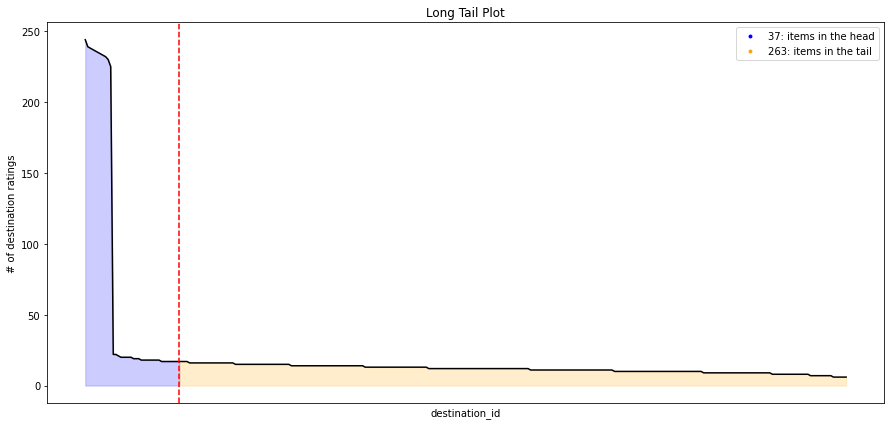

In [232]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="destination_id", 
             interaction_type="destination ratings", 
             percentage=0.5,
             x_labels=False)

In [233]:
# recommendation generated from the KNN generated recommendations
print(similar_ids)

[2, 0, 4, 10, 3, 8, 5, 7, 6, 9]


In [234]:
# reader = Reader(rating_scale=(0, 5))
# data = Dataset.load_from_df(ratings[['user_id', 'destination_id', 'rating']], reader)
# trainset, testset = train_test_split(data, test_size=)
testset=ratings[['user_id','destination_id','rating']]

In [235]:
test = pd.DataFrame(testset)
test.columns = ['user_id', 'destination_id', 'actual']
test

,user_id,destination_id,actual
0,0,1,5.0
1,0,2,5.0
2,0,3,5.0
3,0,4,5.0
4,0,5,5.0
...,...,...,...
6840,249,257,5.0
6841,249,275,4.0
6842,249,277,3.0
6843,249,289,3.0


In [236]:
test = test.copy().groupby('user_id', as_index=False)['destination_id'].agg({'actual': (lambda x: list(set(x)))})
test

,user_id,actual
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 44, 55, 185..."
1,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 154, 291, 1..."
2,2,"[128, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 267, 0, 1..."
3,3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 259, 143, 2..."
4,4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 137, 13, 14..."
...,...,...
239,245,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 133, 135, 2..."
240,246,"[256, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 131, 260,..."
241,247,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 271, 151, 2..."
242,248,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 264, 266, 1..."


In [237]:
print(test['actual'].isnull().sum())

0


In [238]:
test = test.set_index("user_id")
test

,actual
user_id,
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 44, 55, 185..."
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 154, 291, 1..."
2,"[128, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 267, 0, 1..."
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 259, 143, 2..."
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 137, 13, 14..."
...,...
245,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 133, 135, 2..."
246,"[256, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 131, 260,..."
247,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 271, 151, 2..."


In [239]:
# find the recommended 10 destinations to the users of the test dataset
# and add them to a superlist
super_recommended_ids=[]
for user in test.index:
    most_recent_destination_id=test.loc[user]['actual'][-1] #extract the most recently rated destination id
    #print(destinations[destinations["destination_id"]==most_recent_destination_id]["title"])
    collab_recommended_ids = find_similar_destinations(most_recent_destination_id, X, k=10, metric="euclidean")
    content_recommended_ids = get_content_based_recommendations(most_recent_destination_id, n_recommendations=10)
    recommended_ids=list(set(collab_recommended_ids+content_recommended_ids))
    #extract the bayesian avg of all the recommended ids
#     recommended_ids.sort()
    filter_df=destination_stats[destination_stats['destination_id'].isin(recommended_ids)]
    filter_df.sort_values('bayesian_avg',ascending=False,inplace=True)
    recommended_ids=filter_df['destination_id']
    #sort the ids (by their rating)
    recommended_ids=recommended_ids[:10].tolist()
    super_recommended_ids.append(recommended_ids)
# print(super_recommended_ids)

/home/werewolf/.pyenv/versions/data2/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [240]:
# destination_stats

In [241]:
# update the recommended ids as a new column
test['hybrid_predictions']=super_recommended_ids
test.head()

,actual,hybrid_predictions
user_id,,
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 44, 55, 185...","[22, 7, 48, 20, 26, 64, 50, 49, 136, 142]"
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 154, 291, 1...","[97, 22, 48, 24, 20, 74, 96, 226, 76, 64]"
2,"[128, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 267, 0, 1...","[3, 6, 5, 35, 30, 11, 174, 32, 41, 16]"
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 259, 143, 2...","[97, 22, 48, 20, 74, 96, 76, 64, 211, 49]"
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 137, 13, 14...","[151, 252, 120, 89, 93, 129, 130, 189, 219, 185]"


In [242]:
# print(hybrid_predictions)

In [243]:
actual=test['actual'].values.tolist()
hybrid_predictions=test['hybrid_predictions'].values.tolist()
# print(actual)
# print(hybrid_predictions)

### Confusion Matrix

In [244]:
from sklearn.preprocessing import MultiLabelBinarizer

/home/werewolf/.pyenv/versions/data2/lib/python3.9/site-packages/recmetrics/metrics.py:295: RuntimeWarning: invalid value encountered in true_divide
  cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],4)*100


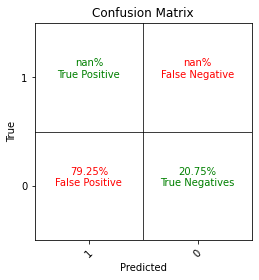

In [245]:
a=MultiLabelBinarizer().fit_transform(actual)
b=MultiLabelBinarizer().fit_transform(hybrid_predictions)
recmetrics.make_confusion_matrix(a.argmax(axis=1), b.argmax(axis=1))

In [246]:
# calculate the mark score
collab_mark = []
for K in np.arange(1, 11):
    collab_mark.extend([recmetrics.mark(actual, hybrid_predictions, k=K)])
collab_mark

[0.018581856732932896,
 0.03763739350757998,
 0.055404848800269656,
 0.06546917992694344,
 0.0746094808391372,
 0.07725096940284924,
 0.0787243421099546,
 0.08026561796928812,
 0.08137653245696043,
 0.0829242838426023]

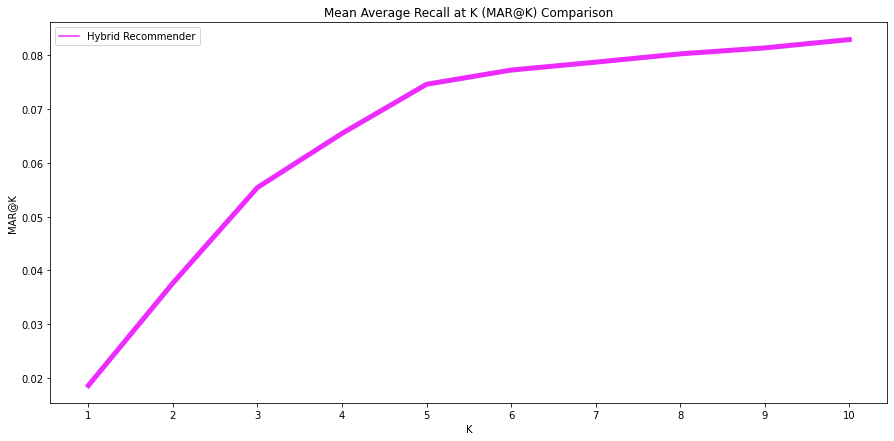

In [247]:
# generate a mark plot
mark_scores = [collab_mark]
index = range(1,10+1)
names = ['Hybrid Recommender']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [248]:
import ml_metrics as metrics

### Similarly, generate MAPK score

In [249]:
collab_mapk = []
for K in np.arange(1, 11):
    collab_mapk.extend([metrics.mapk(actual, hybrid_predictions, k=K)])
collab_mapk

[0.4385245901639344,
 0.4487704918032787,
 0.43897996357012753,
 0.38968579234972683,
 0.35683060109289616,
 0.30897085610200364,
 0.26985056317609013,
 0.2413702673692428,
 0.21738478330008384,
 0.1996626984126984]

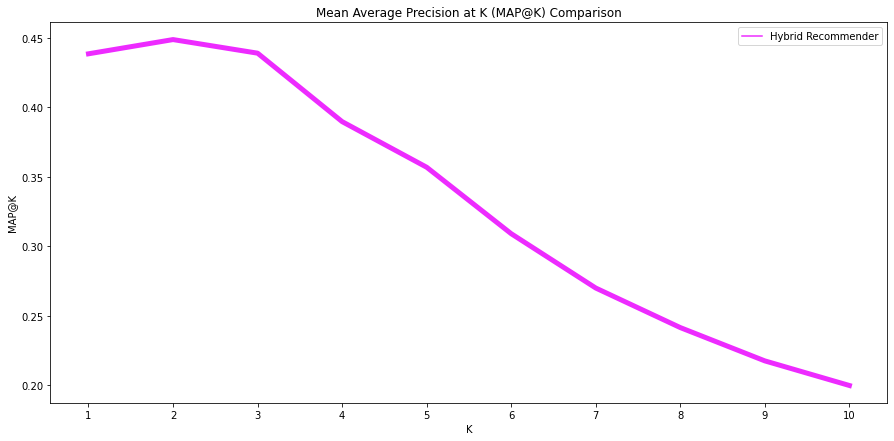

In [250]:
# generate a mapk plot
mapk_scores = [collab_mapk]
index = range(1,10+1)
names = ['Hybrid Recommender']

fig = plt.figure(figsize=(15, 7))
recmetrics.mapk_plot(mapk_scores, model_names=names, k_range=index)

## Calculate the prediction coverage

In [251]:
catalog = ratings.destination_id.unique().tolist()
collab_coverage = recmetrics.prediction_coverage(hybrid_predictions, catalog)
print(collab_coverage)

35.0


## Coverage plot

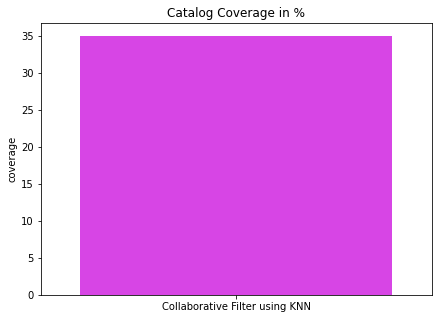

In [252]:
# plot of prediction coverage
coverage_scores = [collab_coverage]
model_names = ['Collaborative Filter using KNN']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

## Intra-list similarity

In [253]:
feature_df=destinations[['history','art_and_architecture','nature','adventure', 'entertainment','health_and_lifestyle',\
                        'food','industries','religious']]
feature_df

,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
0,True,True,False,False,False,False,False,False,True
1,False,False,True,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False
3,True,True,False,False,False,False,False,False,True
4,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
437,False,True,False,False,False,False,False,False,True
438,True,False,False,False,False,False,False,False,False
439,True,False,False,False,False,False,False,False,False
440,True,True,False,False,True,False,False,False,False


In [254]:
recmetrics.intra_list_similarity(hybrid_predictions, feature_df)

0.8722800429775879